In [13]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage.measure import label
from scipy.ndimage import center_of_mass
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import astropy.coordinates as coord
from astropy import units as u
from astropy.coordinates import Angle

#### **Select the 20 brightest objects in the Observation map**

In [14]:
%store -r table_PS_obs

In [3]:
table_PS_obs_sorted = table_PS_obs.sort_values(by='S(Jy)', ascending=False)

top_20 = table_PS_obs_sorted.head(20)

table_PS_obs_brightest = top_20.copy()

In [4]:
table_PS_obs_brightest

,indices,lon(°),lat(°),S(Jy)
0,5787504,167.343750,4.593056,9.692273
1,2769064,194.809570,34.048594,9.488377
2,1760418,250.090618,46.079678,9.044970
3,6983054,124.980469,-6.316817,8.951799
4,2129821,171.342773,41.411189,8.940343
5,8785731,163.388672,-23.358583,8.936742
6,9405489,274.350586,-29.656014,8.573457
7,7129765,59.501953,-7.669783,8.248748
8,1604158,31.992188,48.141208,8.034181
9,392842,249.988713,69.654664,7.935913


In [5]:
%store -r lon
%store -r lat
%store -r xsize
%store -r reso

In [6]:
lon_PS_obs = table_PS_obs_brightest['lon(°)']
lat_PS_obs = table_PS_obs_brightest['lat(°)']

In [7]:
lon_rad = np.radians(lon)
lat_rad = np.radians(lat)
lon_PS_obs_rad = np.radians(lon_PS_obs.values)
lat_PS_obs_rad = np.radians(lat_PS_obs.values)

In [8]:
#reso is in arcmin
def convert_lonlat_to_patch_position(lon_PS, lat_PS, lon_PS_rad, lat_PS_rad, lon = lon, lat = lat, xsize = xsize, reso = reso):
    patch_positions = []

    for lon_PS_rad, lat_PS_rad, lon_PS, lat_PS in zip(lon_PS_rad, lat_PS_rad, lon_PS, lat_PS):
        
        patch_index = np.argmin(coord.angular_separation(lon_PS_rad, lat_PS_rad, lon_rad, lat_rad))

        patch_lon, patch_lat = lon[patch_index], lat[patch_index]

        proj = hp.projector.GnomonicProj(ysize=xsize, xsize=xsize, rot=(patch_lon, patch_lat, 0), reso=reso)
        x, y = proj.ang2xy(lon_PS, lat_PS, lonlat=True)
        i,j = proj.xy2ij(x = x, y = y)
        

        patch_positions.append((patch_index, i, j))

    return patch_positions

In [9]:
brightest20_obs = convert_lonlat_to_patch_position(lon_PS_obs, lat_PS_obs, lon_PS_obs_rad, lat_PS_obs_rad)

In [25]:
%store brightest20_obs

Stored 'brightest20_obs' (list)


#### **Point source only P map**

In [15]:
%store -r B_obs

In [16]:
ps_map_B_obs_patches = [hp.gnomview(B_obs, rot=[lon[i], lat[i]], xsize = xsize, reso = reso, return_projected_map = True, no_plot = True) for i in range(len(lon))]

#### **Patch comparison**

In [17]:
# Store the prediction
%store -r prediction_B_64pix_9epoch_10batch

In [18]:
# Store the observation
%store -r map_cut_data_B_obs

In [19]:
patch_numbers = [item[0] for item in brightest20_obs]
peak_patch_x = [item[2] for item in brightest20_obs]
peak_patch_y = [item[1] for item in brightest20_obs]

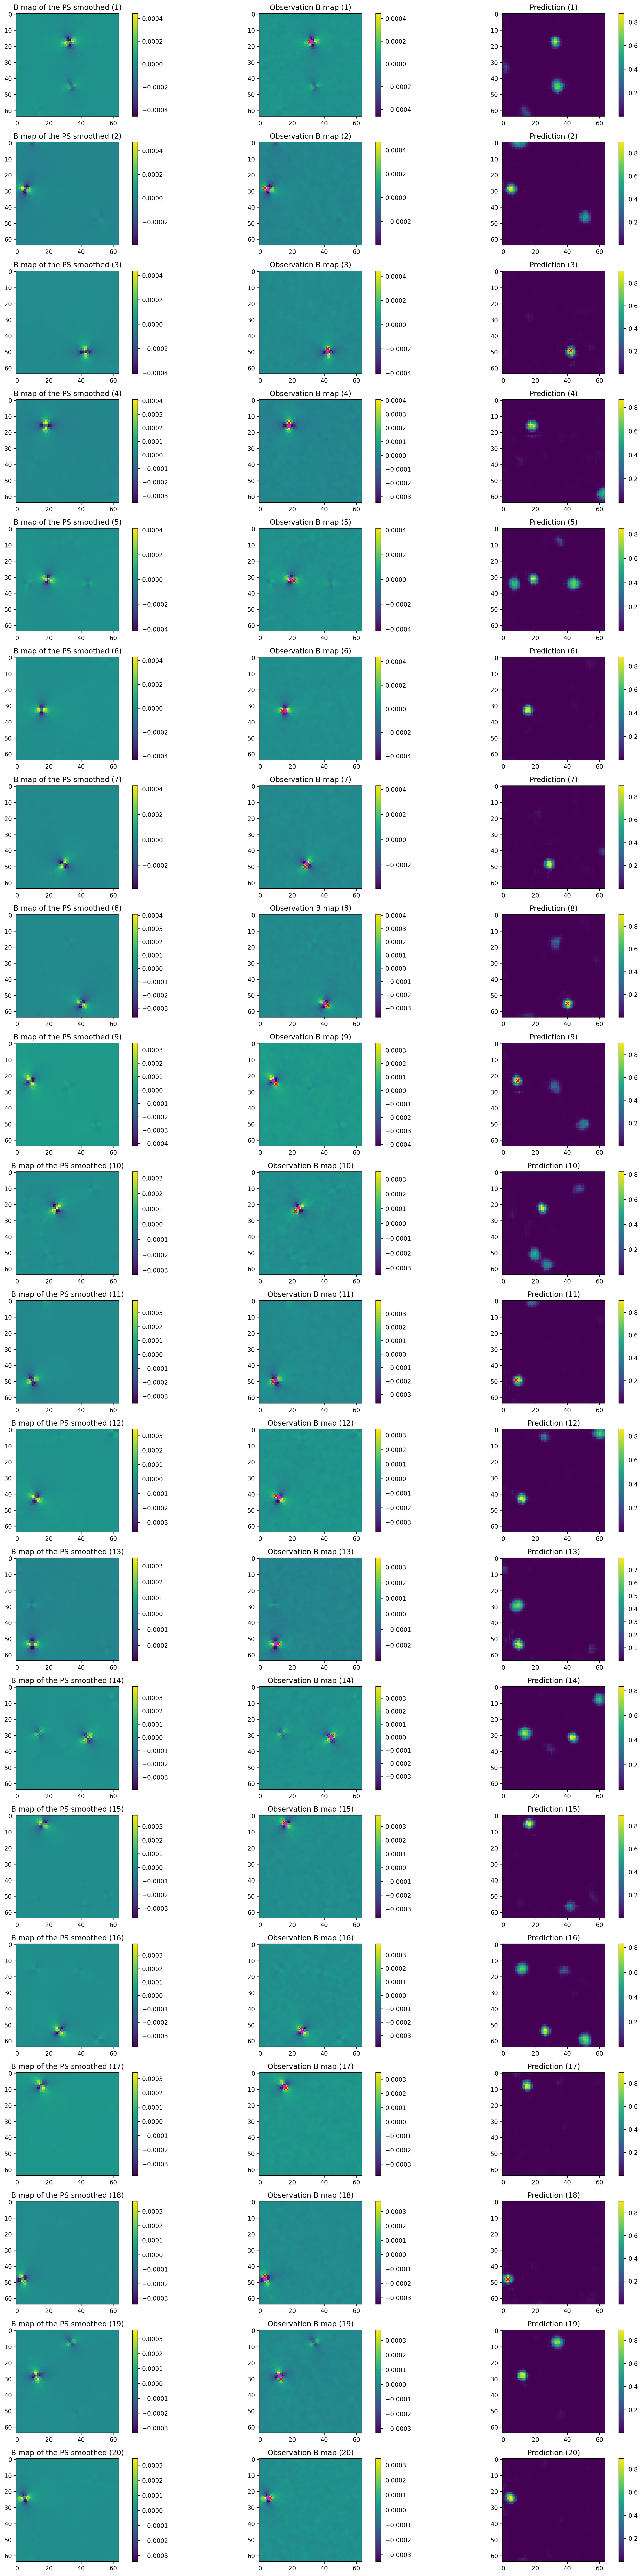

In [24]:
fig, axes = plt.subplots(20, 3, figsize=(18, 60), dpi=200)

for i, (patch_number, peak_x, peak_y) in enumerate(zip(patch_numbers[:20], peak_patch_x[:20], peak_patch_y[:20])):
    
    def test(observation, prediction, n=patch_number, peak_distance_tol=5, position_tol=5): 
        observation = np.squeeze(observation[n])
        prediction = np.squeeze(prediction[n])
        observation_peaks = peak_local_max(observation[:, :], threshold_rel=0.9, min_distance=peak_distance_tol, exclude_border=False)
        prediction_peaks = peak_local_max(prediction[:, :], threshold_abs=0.9, min_distance=peak_distance_tol, exclude_border=False)
        true_detections = []
        for observation_peak in observation_peaks:
            for pred_peak in prediction_peaks:
                distance = np.sqrt((observation_peak[0] - pred_peak[0]) ** 2 + (observation_peak[1] - pred_peak[1]) ** 2)
                if distance <= position_tol:
                    true_detections.append((observation_peak, pred_peak))

        false_detections = len(prediction_peaks) - len(true_detections)
        return true_detections, false_detections, prediction_peaks, observation_peaks, observation, prediction  
    
        
    # S_new_obs plot
    ax1 = axes[i, 0]    
    sc1 = ax1.imshow(ps_map_B_obs_patches[patch_number])
    cbar1 = fig.colorbar(sc1, ax=ax1)
    ax1.set_title(f"B map of the PS smoothed ({i+1})")

        
    # Observation
    ax2 = axes[i, 1]  
    image_data2 = test(map_cut_data_B_obs, prediction_B_64pix_9epoch_10batch)[4]
    sc2 = ax2.imshow(image_data2)
    ax2.scatter(x=test(map_cut_data_B_obs, prediction_B_64pix_9epoch_10batch)[3][:, 1],
                y=test(map_cut_data_B_obs, prediction_B_64pix_9epoch_10batch)[3][:, 0], c='red', marker='x')
    ax2.scatter(x=peak_x, y=peak_y, color='magenta', s=20)
    cbar2 = fig.colorbar(sc2, ax=ax2)
    ax2.set_title(f"Observation B map ({i+1})")

    
    # Prediction
    ax3 = axes[i, 2]  
    image_data3 = test(map_cut_data_B_obs, prediction_B_64pix_9epoch_10batch)[5]
    sc3 = ax3.imshow(image_data3)
    ax3.scatter(x=test(map_cut_data_B_obs, prediction_B_64pix_9epoch_10batch)[2][:, 1],
                y=test(map_cut_data_B_obs, prediction_B_64pix_9epoch_10batch)[2][:, 0], c='red', marker='x')
    cbar3 = fig.colorbar(sc3, ax=ax3)
    ax3.set_title(f"Prediction ({i+1})")



plt.tight_layout()  
plt.savefig('Patches_B_0.9threshold.pdf', format='pdf')
plt.show()
